# Homework 4 : Applied Machine Learning

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import sklearn.cluster
from collections import Counter
%matplotlib inline

In [2]:
# import data
df = pd.read_csv('CrowdstormingDataJuly1st.csv', index_col=0)
df.head()

,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
playerShort,,,,,,,,,,,,,,,,,,,,,
lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [3]:
df.isnull().sum()

player               0
club                 0
leagueCountry        0
birthday             0
height             263
weight            2243
position         17726
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID          21407
rater1           21407
rater2           21407
refNum               0
refCountry           0
Alpha_3              1
meanIAT            163
nIAT               163
seIAT              163
meanExp            163
nExp               163
seExp              163
dtype: int64

We can see that we still have missing values in these fields:
* height
* weight
* position
* photoID
* rater1
* rater2
* meanIAT
* nIAT
* meanExp
* nExp
* seExp

IAT and Exp features are exogenous to the players, we won't include it in the player description for Part.1 
rater1 and rater2 missing entries come from the missing photos, we can simply drop the corresponding lines.
Weight and height was dropped as well as it corresponded to only 24 unique players (in the worst case) out of 1585.
The missing position was handled by the dummy encoding of this variable

In [4]:
# drop rows for which we have no photo (and thus no skin rating)
df.dropna(subset=['rater1', 'rater2', 'weight', 'height'], inplace=True)

# group by players
group_by_players = df.groupby(level=0)

# build the data used for later analysis

# for league country, keep only the one that appears the most for one player
player_description = group_by_players.agg({'leagueCountry': lambda x: x.value_counts().index[0],
                                           'position': 'first',
                                           'height': 'mean', 
                                           'weight': 'mean',
                                           'games': 'sum',
                                           'victories': 'sum',
                                           'ties': 'sum',
                                           'defeats': 'sum',
                                           'goals': 'sum',
                                           'yellowCards': 'sum',
                                           'yellowReds': 'sum',
                                           'redCards': 'sum',
                                           'rater1': 'first',
                                           'rater2': 'first'
                                          })

# dummy encoding of the categorical variables with handling of missing values
player_description = pd.get_dummies(player_description, dummy_na= True, columns = ['leagueCountry', 'position'])
player_description.head()

,weight,height,goals,yellowCards,ties,defeats,games,victories,yellowReds,redCards,...,position_Center Midfielder,position_Defensive Midfielder,position_Goalkeeper,position_Left Fullback,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger,position_nan
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,71.0,182.0,9,19,179,228,654,247,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-hunt,73.0,183.0,62,42,73,122,336,141,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-lennon,63.0,165.0,31,11,97,115,412,200,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
aaron-ramsey,76.0,178.0,39,31,42,68,260,150,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abdelhamid-el-kaoutari,73.0,180.0,1,8,40,43,124,41,4,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


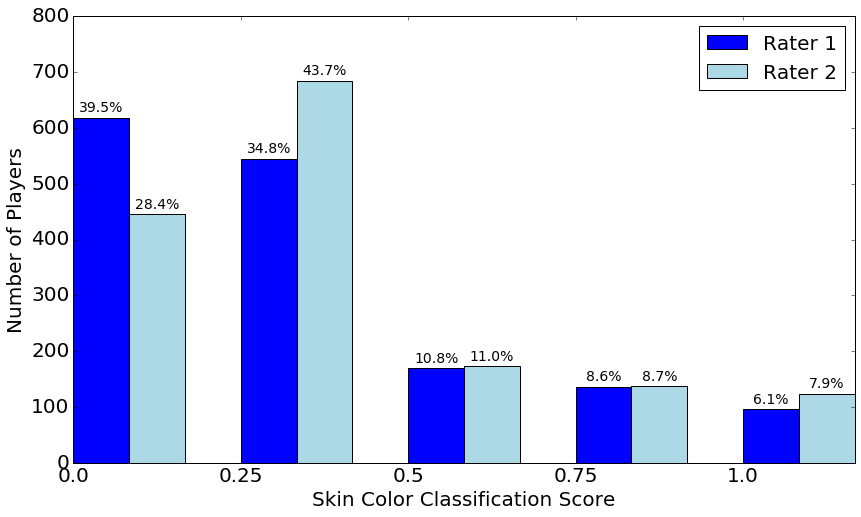

In [5]:
def hist_raters(data_by_player) :
    vals1 = data_by_player['rater1'].tolist()
    vals2 = data_by_player['rater2'].tolist()
    total_number_player = len(vals1)
    labels1, values1 = zip(*sorted(Counter(vals1).items()))
    indexes1 = np.arange(len(labels1))*3
    labels2, values2 = zip(*sorted(Counter(vals2).items()))
    indexes2 = np.arange(len(labels2))*3+1
    width = 1
    fig1 = plt.figure(figsize=(14,8))
    bar1 = plt.bar(indexes1, values1, width, tick_label=1, color='blue', label='Rater 1')
    bar2 = plt.bar(indexes2, values2, width, tick_label=1, color='lightblue', label='Rater 2')
    rects1 = bar1.patches
    rects2 = bar2.patches
    lab1 = ["{}%".format(int(values1[i]/total_number_player*1000)/10) for i in range(len(rects1))]
    lab2 = ["{}%".format(int(values2[i]/total_number_player*1000)/10) for i in range(len(rects2))]
    for rect, label in zip(rects1, lab1):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=14)
    for rect, label in zip(rects2, lab2):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=14)
    plt.ylim([0,800])
    plt.legend(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(indexes1,labels1,fontsize=20)
    plt.xlabel('Skin Color Classification Score', fontsize=20)
    plt.ylabel('Number of Players', fontsize=20);
    
hist_raters(player_description)

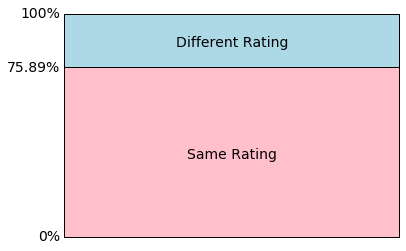

In [6]:
def hist_ratings(data_by_player):
    dict1 = data_by_player['rater1'].to_dict()
    dict2 = data_by_player['rater2'].to_dict()
    intersect = dict(set.intersection(*(set(d.items()) for d in [dict1, dict2])))
    total_nbr = len(dict1)
    common_nbr = len(intersect)/total_nbr*100
    fig1, ax1 = plt.subplots(figsize=(6, 4))
    bar1 = plt.bar([0], common_nbr, width=1, color='pink', label='Rater 1')
    bar2 = plt.bar([0], ((total_nbr-len(intersect))/total_nbr)*100,
                   width=1,bottom=common_nbr, color='lightblue', label='Rater 2')
    plt.ylim([0,100])
    plt.tick_params(axis='both',which='both',bottom='off',top='off',labelbottom='off')
    ax1.yaxis.set_ticklabels(['{}%'.format(0),'{}%'.format(int(common_nbr*100)/100),'{}%'.format(100)])
    plt.yticks([0,common_nbr,100],fontsize=14)
    previous_height = 0
    for rect, label in zip(bar1.patches + bar2.patches, ['Same Rating','Different Rating']):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, previous_height + height/2-4,
                 label, ha='center', va='bottom', fontsize=14)
        previous_height = height
    plt.xlim([0,1]);
    
hist_ratings(player_description)

In [7]:
# labels
player_rating = player_description['rater1']

player_description.drop(['rater1', 'rater2'], axis=1, inplace=True)


## Training the classifier

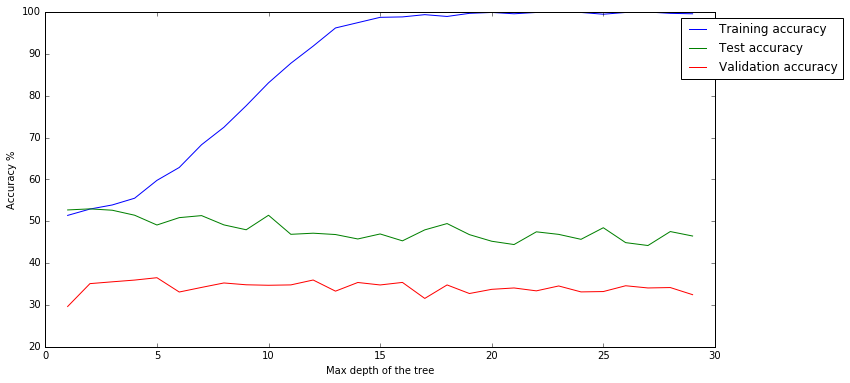

In [9]:
import warnings
warnings.filterwarnings('ignore')

X = player_description.as_matrix()
y = (player_rating*4).as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
tr_accuracy = []
te_accuracy = []
cross = []
for n in [20]:
    for d in range(1,30):
        model = RandomForestClassifier(n_estimators=n, max_depth=d)
        c = sklearn.cross_validation.cross_val_score(model, X_train, y_train, cv=20, scoring='f1_weighted')
        cross.append(np.mean(c)*100)
        model.fit(X_train, y_train)

        te_pred = model.predict(X_test)
        tr_pred = model.predict(X_train)

        tr_acc = sklearn.metrics.f1_score(tr_pred, y_train, average='weighted')*100

        te_acc = sklearn.metrics.f1_score(te_pred, y_test, average='weighted')*100

        tr_accuracy.append(tr_acc)
        te_accuracy.append(te_acc)
plt.figure(figsize=(12,6))    
plt.plot(range(1,30), tr_accuracy, label='Training accuracy')
plt.plot(range(1,30), te_accuracy, label='Test accuracy');
plt.plot(range(1,30), cross, label='Validation accuracy');
plt.ylabel('Accuracy %')
plt.xlabel('Max depth of the tree')
plt.legend(bbox_to_anchor=(1.2, 1));

### Effect of the parameters on the classifier
Several parameters were tried for the classifier, only the max depth of the tree is shown above. As the depth of the tree increase we clearly see that the model overfit as the trainig accuracy goes to 100% accuracy and the test accuracy decrease a little bit. Using cross-validation we can mitigate the over-fitting effect as shown on the red curve.

### Feature Importance

In [10]:
final_model = RandomForestClassifier(n_estimators=20, max_depth=10)
final_model.fit(X, y)


importances = final_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

col = player_description.columns

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, col[indices[f]], importances[indices[f]]))


1. feature yellowCards (0.102781)
2. feature victories (0.100259)
3. feature height (0.099949)
4. feature defeats (0.094450)
5. feature games (0.086373)
6. feature goals (0.083727)
7. feature weight (0.080796)
8. feature ties (0.080782)
9. feature redCards (0.038813)
10. feature leagueCountry_Germany (0.033436)
11. feature yellowReds (0.032339)
12. feature leagueCountry_Spain (0.021216)
13. feature leagueCountry_France (0.019204)
14. feature leagueCountry_England (0.017110)
15. feature position_Center Back (0.012561)
16. feature position_Defensive Midfielder (0.011882)
17. feature position_nan (0.011491)
18. feature position_Left Fullback (0.009193)
19. feature position_Right Fullback (0.009048)
20. feature position_Goalkeeper (0.008876)
21. feature position_Right Winger (0.008361)
22. feature position_Center Forward (0.007676)
23. feature position_Left Midfielder (0.007002)
24. feature position_Attacking Midfielder (0.006674)
25. feature position_Right Midfielder (0.005544)
26. featur

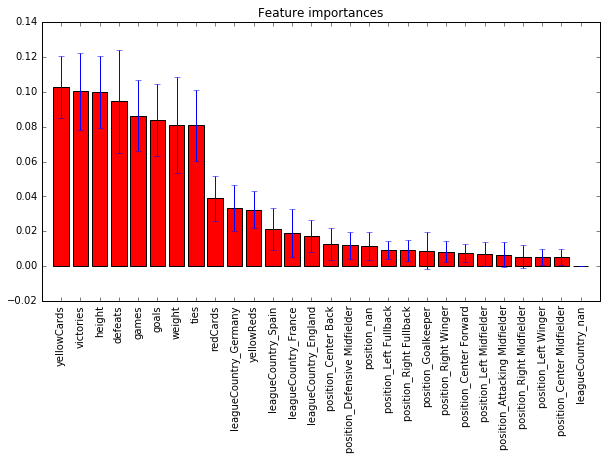

In [11]:
# Plot the feature importances of the forest
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices],  align='center')
plt.xticks(range(X.shape[1]), col[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

We can see that 8 features seem to emerge from the rest : weight, defeats, victories, yellowCards, games, height, ties and goals are the most important. redCards, yellowReds, the league country and the position seem to be non informative

### Experiments with different features
We try to fit the model with different subsets of the data and see the evolution of the feature importance ranking

In [12]:
subset_cols = col[indices[0:8]]
player_description_subset = player_description[list(subset_cols)]

X_subset = player_description_subset.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3)


model2 = RandomForestClassifier(n_estimators=20, max_depth=10)
model2.fit(X_train, y_train)

te_pred = model2.predict(X_test)
tr_pred = model2.predict(X_train)

tr_acc = tr_pred == y_train
tr_acc = np.sum(tr_acc)/len(tr_acc) * 100

te_acc = te_pred == y_test
te_acc = np.sum(te_acc)/len(te_acc) * 100
print('Training accuracy: %.2f, Test accuracy: %.2f' % (tr_acc, te_acc))

Training accuracy: 76.60, Test accuracy: 40.64


In [13]:
player_description_subset.head()

,yellowCards,victories,height,defeats,games,goals,weight,ties
playerShort,,,,,,,,
aaron-hughes,19,247,182.0,228,654,9,71.0,179
aaron-hunt,42,141,183.0,122,336,62,73.0,73
aaron-lennon,11,200,165.0,115,412,31,63.0,97
aaron-ramsey,31,150,178.0,68,260,39,76.0,42
abdelhamid-el-kaoutari,8,41,180.0,43,124,1,73.0,40


In [14]:
importances = model2.feature_importances_
std = np.std([tree.feature_importances_ for tree in model2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

col = player_description_subset.columns

for f in range(X_subset.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, col[indices[f]], importances[indices[f]]))


1. feature weight (0.138690)
2. feature victories (0.132512)
3. feature defeats (0.127683)
4. feature ties (0.127308)
5. feature games (0.125113)
6. feature goals (0.119723)
7. feature yellowCards (0.116296)
8. feature height (0.112676)


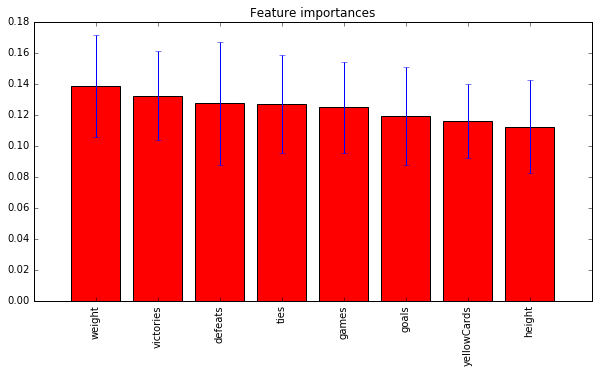

In [15]:
# Plot the feature importances of the forest
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X_subset.shape[1]), importances[indices],
       color="r", yerr=std[indices],  align='center')
plt.xticks(range(X_subset.shape[1]), col[indices], rotation=90)
plt.xlim([-1, X_subset.shape[1]])
plt.show()

Observations.
* by keeping only subsets of the 8 relevant features, we see that the exact ordering of the feature importance changes but the relative difference of importance is negligible. Thus we can conclude that there is not substantial difference in the feature importance.

### Unsupervised learning : Data processing

We first do a simple mean, for each player, of all the features related to the referee.

In [16]:
basic = df[['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']] #Select the feature to use
basic.dropna(subset=['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'], inplace=True)


ref_basic = basic.groupby(level=0).mean() #groupby player and apply the mean for each feature
ref_basic.drop(['nIAT', 'nExp'], axis=1, inplace=True) #drop the sample size are they are not meaningful in this case

df2 = df[['rater1', 'rater2']].groupby(df.index).first() #get the skin color rate of the original dataframe
df2['skin'] = df2.apply(lambda x: (x['rater1'] + x['rater2'])/2, axis=1) #compute the mean of the rates
skin = df2['skin'] < 0.5 #threshold the skin rate 

Once we tried the simple model above, we tried something a bit more complicated by weighted each mean of the IAT and EXP by the number of sample used to get them

In [17]:
import warnings
warnings.filterwarnings('ignore')

# Get the feature as before
df1 = df[['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']]
df1.dropna(subset=['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'], inplace=True)

# Multiply the number of sample and the mean to weight the mean
df1['mIAT'] = df1.apply(lambda x: x.loc['meanIAT']*x.loc['nIAT'], axis=1)
df1['sIAT'] = df1.apply(lambda x: x.loc['seIAT']*x.loc['nIAT'], axis=1)
df1['mExp'] = df1.apply(lambda x: x.loc['meanExp']*x.loc['nExp'], axis=1)
df1['sExp'] = df1.apply(lambda x: x.loc['seExp']*x.loc['nExp'], axis=1)

group_player = df1.groupby(df1.index) #groupby players

#Add the previous festures in a dataframe
ref = group_player.agg({'nIAT': 'sum',
                        'mIAT': 'sum',
                        'sIAT': 'sum',
                        'nExp': 'sum',
                        'mExp': 'sum',
                        'sExp': 'sum'     
    })

#Calculate the weighted mean for each player from the new values
ref['mIAT'] = ref['mIAT']/ref['nIAT'] #
ref['mExp'] = ref['mExp']/ref['nExp']

ref['sIAT'] = ref['sIAT']/ref['nExp']
ref['sExp'] = ref['sExp']/ref['nExp']

ref.drop(['nIAT', 'nExp'], axis=1, inplace=True)

In [55]:
#Method to apply kMean on the data, calculate the accuracy and the silhouette score
def cluster(ref, col):

    sil = []
    f1 = []
    feature = []
    
    for i in col:
        for j in i:
            kMean = sklearn.cluster.KMeans(n_clusters=2, init='k-means++', n_init=10).fit(ref[list(j)]) #kmean clustering
            silhouette = sklearn.metrics.silhouette_score(ref[list(j)], kMean.labels_) #Calculate silhouette score
            #Calculate accuracy. We Use max because we don't know which category represent "white" and which represent "Black"
            f1_score = max(sklearn.metrics.accuracy_score(skin, kMean.labels_), 
                           sklearn.metrics.accuracy_score(~skin, kMean.labels_))
            sil.append(silhouette)
            f1.append(f1_score)
            feature.append(j)
            
    return sil, f1, feature

In [56]:
#Create all the possible combinations of features and apply kmean on each of them
import itertools
#Combinations for simple model
col = []
for r in range(1,5):
    col.append(list(itertools.combinations(ref.columns, r)))

#Combinations for Second model
col1 = []
for r in range(1,5):
    col1.append(list(itertools.combinations(ref_basic.columns, r)))

#Apply kmean and calculate scores
sil_basic, f1_basic, feature_basic = cluster(ref_basic, col1)
sil, f1, feature = cluster(ref, col)

### Result with the simple model

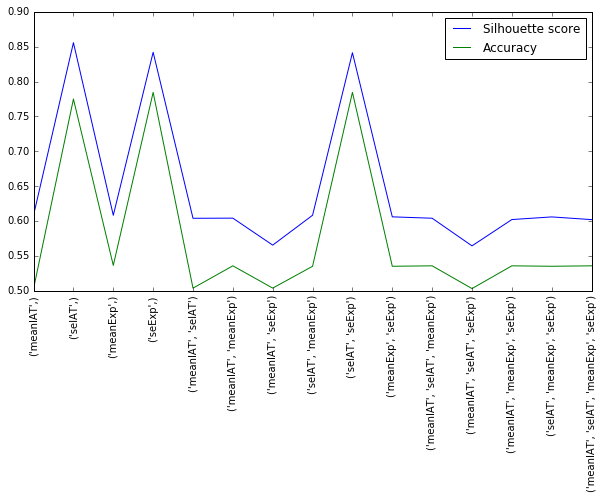

In [70]:
plt.figure(figsize=(10,5))
plt.plot(range(15), sil_basic, label='Silhouette score')
plt.plot(range(15), f1_basic, label='Accuracy')
plt.xticks(range(15),feature_basic, rotation='vertical');
plt.legend();

### Result with second model

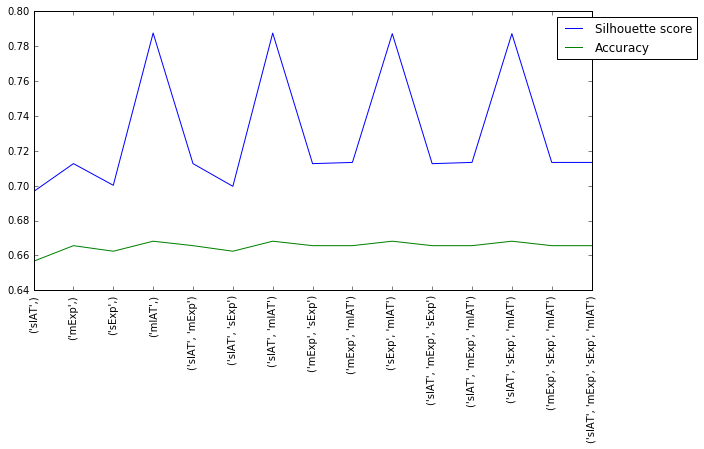

In [69]:
plt.figure(figsize=(10,5))
plt.plot(range(15), sil, label='Silhouette score')
plt.plot(range(15), f1, label='Accuracy')
plt.legend(bbox_to_anchor=(1.2, 1));
plt.xticks(range(15),feature, rotation='vertical');

As we can see, using a more complicated model is worse in term of accuracy and silhouette score. Even if in both cases we see that the silhouette score can be close to 1 if we choose carefully our features. Those results should be taken carefully as Kmean depends a lot of the initialization points. Furthermore as we are using the accuracy function we don't take into account the fact that the distribution of "white" and "black" is not uniform (we have more "white" people than "black" one in our sample.